#### <b>라이브러리 불러오기</b>

* 필요한 라이브러리를 불러온다.

In [ ]:
import numpy as np # 데이터 처리를 위한 NumPy 라이브러리 불러오기
import matplotlib.pyplot as plt # 데이터 시각화 라이브러리 불러오기

import torch # PyTorch 라이브러리 불러오기
# PyTorch의 컴퓨터 비전 라이브러리의 손글씨 데이터 세트인 MNIST 불러오기
from torchvision.datasets.mnist import MNIST
# 이미지를 PyTorch의 텐서(tensor) 형태로 변경하여 처리하기 위한 transforms 라이브러리
from torchvision.transforms import ToTensor

#### <b>추가적인 함수 정의</b>

* Gaussian Noise 삽입 함수를 정의한다.

In [ ]:
# 이미지에 가우시안 노이즈를 추가하는 함수
def gaussian_noise(x, scale=0.5):
     # 이미지 x는 [0, 255]의 값을 가지는 상태에서 [0, 1]로 scaling 수행 이후의 값
     # 노이즈를 정의
     noise = np.random.normal(
        loc=0, # 평균
        scale=0.5, # 표준 편차
        size=x.shape
     )
     noise_x = x + noise

     # 이미지 픽셀 값이 [0, 1] 사이의 값이 되도록 clipping (튀어나온 부분을 잘라냄)
     noise_x = np.clip(noise_x, 0, 1)
     # PyTorch의 Tensor 객체로 변환
     noise_x = torch.Tensor(noise_x)
     noise_x = noise_x.type(torch.FloatTensor)
     return noise_x

#### <b>데이터 세트 정의</b>

100%|██████████| 9912422/9912422 [00:00<00:00, 350037560.47it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 43573990.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 105568399.15it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6260443.24it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



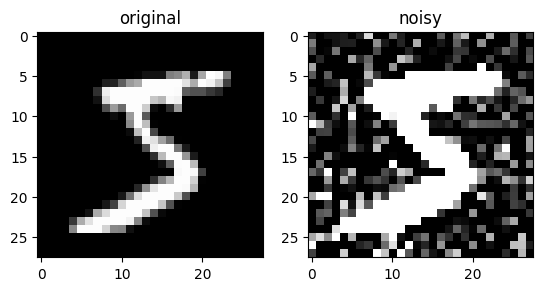

In [ ]:
# 학습용 데이터 세트 정의
training_dataset = MNIST(
    root="./data", # 데이터를 다운로드할 경로
    train=True, # 학습 데이터를 불러올 것인지 설정
    download=True, # 데이터 세트가 현재 컴퓨터에 없다면, 다운로드
    transform=ToTensor() # 기본적으로 픽셀 값은 [0, 255]이므로, [0, 1]로 scaling
)

# 평가용 데이터 세트 정의
test_dataset = MNIST(
    root="./data", # 데이터를 다운로드할 경로
    train=False, # 학습 데이터를 불러올 것인지 설정
    download=True, # 데이터 세트가 현재 컴퓨터에 없다면, 다운로드
    transform=ToTensor() # 기본적으로 픽셀 값은 [0, 255]이므로, [0, 1]로 scaling
)

# 첫 번째 원본 이미지
img = training_dataset.data[0]
# 해당 이미지에 노이즈를 섞기
noise_img = gaussian_noise(img)

# 두 개의 이미지를 출력
plt.subplot(1, 2, 1) # [1 X 2] 크기의 이미지에서 1번째 위치에 이미지 표시
plt.title("original")
plt.imshow(img, cmap="gray") # cmap은 color map을 설정하는 속성
plt.subplot(1, 2, 2) # [1 X 2] 크기의 이미지에서 2번째 위치에 이미지 표시
plt.title("noisy")
plt.imshow(noise_img, cmap="gray") # cmap은 color map을 설정하는 속성

In [ ]:
from torch.utils.data.dataset import Dataset


class Denoising(Dataset):
    # ① __init__(): 불러올 데이터에 대한 개괄적인 내용
    def __init__(self):
        # MNIST 데이터 세트 불러오기
        self.mnist = MNIST(
            root="./data", # 데이터를 다운로드할 경로
            train=True, # 학습 데이터를 불러올 것인지 설정
            download=True, # 데이터 세트가 현재 컴퓨터에 없다면, 다운로드
            transform=ToTensor() # 기본적으로 픽셀 값은 [0, 255]이므로, [0, 1]로 scaling
        )
        # 노이즈가 포함된 이미지를 담는 리스트
        self.noise_data = []

        # 모든 데이터에 노이즈 입히기
        for i in range(len(self.mnist)):
            noise_x = gaussian_noise(self.mnist.data[i])
            # 크기: [28, 28]
            noise_x = torch.tensor(noise_x)
            # 채널(channel) 축을 추가하기 위해 [1, 28, 28]로 변경
            self.noise_data.append(torch.unsqueeze(noise_x, dim=0))

    # ② __len__(): 현재 데이터 세트에 포함된 총 데이터의 개수
    def __len__(self):
      return len(self.noise_data)

    # ③ __getitem__(): 특정한 인덱스에 해당하는 데이터를 반환하는 함수
    def __getitem__(self, idx):
        data = self.noise_data[idx]

        # 정답 데이터도 0과 1 사이의 값으로 맞추어 주기
        label = self.mnist.data[idx] / 255 # ToTensor() 함수랑 같은 의미

        # 입력 이미지(data)와 출력 이미지(label) 반환
        return data, label

In [ ]:
train_dataset = Denoising()

<ipython-input-16-258e8bde6c00>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_x = torch.tensor(noise_x)


In [ ]:
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

torch.Size([1, 28, 28]) torch.Size([28, 28])


#### <b>딥러닝 모델 정의</b>

In [ ]:
import torch.nn as nn # PyTorch Neural Networks (nn) 라이브러리


# 일반적으로 CNN에서 블록(block)이란, 여러 개의 convolution layer로 구성된 것을 의미
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, hidden_dim):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels, # 입력 텐서의 채널(channel) 수와 동일
            hidden_dim, # 사용할 커널의 개수
            kernel_size=3, # 사용할 커널의 크기
            # (3 X 3) 커널을 쓸 때 padding=1이면, 해상도 손실 없음
            padding=1 # 해상도를 줄이지 않기 위해 사용
        )
        self.conv2 = nn.Conv2d(
            hidden_dim, # 입력 텐서의 채널(channel) 수와 동일
            out_channels, # 사용할 커널의 개수
            kernel_size=3, # 사용할 커널의 크기
            # (3 X 3) 커널을 쓸 때 padding=1이면, 해상도 손실 없음
            padding=1 # 해상도를 줄이지 않기 위해 사용
        )
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)

        return x

In [ ]:
BasicBlock(1, 16, hidden_dim=8)

BasicBlock(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU()
)

In [ ]:
# 이미지에서 특징을 추출하는 인코더 네트워크
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # 흑백 이미지이므로, 입력 채널은 1개
        self.block1 = BasicBlock(in_channels=1, out_channels=16, hidden_dim=16)
        self.block2 = BasicBlock(in_channels=16, out_channels=8, hidden_dim=8)

        # 인코더이므로, 해상도를 줄이는 기능 수행
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2) # 가로와 너비를 2배씩 감소

    # 일반적인 CNN 분류 모델처럼 해상도를 줄이며, 특징 추출
    def forward(self, x):
        # [1, 28, 28]
        x = self.block1(x)
        # [16, 28, 28]
        x = self.pool(x)
        # [16, 14, 14]
        x = self.block2(x)
        # [8, 14, 14]
        x = self.pool(x)
        # [8, 7, 7]

        return x

In [ ]:
Encoder()

Encoder(
  (block1): BasicBlock(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (block2): BasicBlock(
    (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
)

In [ ]:
# 특징에서 다시 원본 이미지를 복원하는 디코더 네트워크
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()

        # 흑백 이미지이므로, 입력 채널은 1개
        self.block1 = BasicBlock(in_channels=8, out_channels=8, hidden_dim=8) # → upsample1에서 8
        self.block2 = BasicBlock(in_channels=8, out_channels=16, hidden_dim=16) # → upsample2에서 16

        # 출력을 위한 블록(block)이므로, 출력 채널은 1의 크기로 설정
        self.output_conv = nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1)

        # 디코더이므로, 해상도를 늘리는 기능 수행
        self.upsample1 = nn.ConvTranspose2d(8, 8, kernel_size=2, stride=2) # 가로와 너비를 2배씩 증가
        self.upsample2 = nn.ConvTranspose2d(16, 16, kernel_size=2, stride=2) # 가로와 너비를 2배씩 증가

    # 일반적인 CNN 분류 모델처럼 해상도를 줄이며, 특징 추출
    def forward(self, x):
        # [8, 7, 7]
        x = self.block1(x)
        # [8, 7, 7]
        x = self.upsample1(x)
        # [8, 14, 14]
        x = self.block2(x)
        # [16, 14, 14]
        x = self.upsample2(x)
        # [16, 28, 28]
        x = self.output_conv(x)
        # [1, 28, 28]

        return x

In [ ]:
Decoder()

Decoder(
  (block1): BasicBlock(
    (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (block2): BasicBlock(
    (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
  )
  (output_conv): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upsample1): ConvTranspose2d(8, 8, kernel_size=(2, 2), stride=(2, 2))
  (upsample2): ConvTranspose2d(16, 16, kernel_size=(2, 2), stride=(2, 2))
)

In [ ]:
# CAE (Convolutional Auto-Encoder) 모델 정의하기
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()

        self.encoder = Encoder() # 인코더 네트워크 초기화
        self.decoder = Decoder() # 디코더 네트워크 초기화

    # 하나의 입력이 주어지면, 인코더와 디코더를 거친 결과를 출력
    def forward(self, x):
        x = self.encoder(x) # 인코더를 이용해 특징 추출
        x = self.decoder(x) # 디코더를 이용해 노이즈가 제거된 이미지 복원
        x = torch.squeeze(x) # 첫 번째 채널을 삭제

        return x

In [ ]:
CAE()

CAE(
  (encoder): Encoder(
    (block1): BasicBlock(
      (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (block2): BasicBlock(
      (conv1): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Decoder(
    (block1): BasicBlock(
      (conv1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (block2): BasicBlock(
      (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
    )
    (output_conv): Conv2d(16, 1, kerne

#### <b>딥러닝 모델 학습하기</b>

In [ ]:
import tqdm # 학습 과정 시각화 라이브러리

from torch.utils.data.dataloader import DataLoader
from torch.optim.adam import Adam

train_dataset = Denoising() # 노이즈 제거 기능을 위한 데이터 세트
train_loader = DataLoader(train_dataset, batch_size=32)

<ipython-input-16-258e8bde6c00>:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  noise_x = torch.tensor(noise_x)


In [ ]:
model = CAE().cuda() # 학습할 전체 모델을 GPU에 업로드

# 하이퍼 파라미터 설정
lr = 0.001
optim = Adam(params=model.parameters(), lr=lr)
criterion = nn.MSELoss()

for epoch in range(20):
    iterator = tqdm.tqdm(train_loader) # 학습 과정을 시각화하기 위해 tqdm 사용

    for inputs, labels in iterator:
        # 입력과 출력을 GPU에 업로드
        inputs = inputs.cuda()
        labels = labels.cuda()

        optim.zero_grad() # ① 일단 모델 가중치의 기울기(gradient) 초기화
        pred = model(inputs) # ② 모델에 입력하여 추론 결과 확인
        loss = criterion(pred, labels) # ③ 모델의 예측 결과와 정답을 비교하여 손실 계산
        loss.backward() # ④ 역전파를 통해 모델의 가중치에 대한 기울기 계산
        optim.step() # ⑤ 계산된 기울기를 이용해 모델 가중치 업데이트

        # 로그 시각화
        iterator.set_description(f"[Epoch {epoch + 1}] loss: {loss.item()}")

[Epoch 20] loss: 0.006738756317645311: 100%|██████████| 1875/1875 [00:14<00:00, 131.36it/s]


In [ ]:
# 학습된 모델 저장
torch.save(model.state_dict(), "./CAE.pt") # 학습된 모델의 가중치를 사전 자료형으로 저장

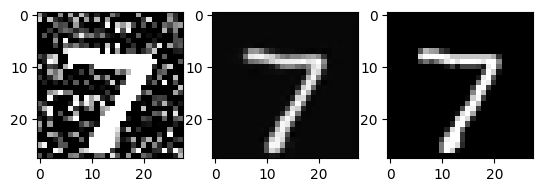

In [ ]:
# 학습된 모델 성능 평가
model.load_state_dict(torch.load("./CAE.pt"))
model = model.cuda()

# 평가할 때는 기울기 추적이 필요 없으므로, 결과만 출력
with torch.no_grad():
    img = test_dataset.data[0] # 한 장의 테스트 이미지 준비
    noise_img = gaussian_noise(img) # 해당 테스트 이미지에 노이즈 삽입

    # 모델에 입력으로 삽입(forward)
    input = torch.unsqueeze(noise_img, dim=0) # 채널 축(axis) 추가
    input.type(torch.FloatTensor) # 모델 가중치와 동일하게 실수 자료형으로 변환
    input = input.cuda()
    input = torch.unsqueeze(input, dim=0) # 배치 축(axis) 추가

    # 노이즈 이미지 시각화
    plt.subplot(1, 3, 1) # [1, 3] 크기의 이미지의 1번째 이미지로 시각화
    plt.imshow(torch.squeeze(noise_img), cmap="gray") # 배치 축 및 채널 축 제거 필요
    # 모델의 예측 결과 이미지 시각화
    plt.subplot(1, 3, 2) # [1, 3] 크기의 이미지의 2번째 이미지로 시각화
    plt.imshow(torch.squeeze(model(input).cpu()), cmap="gray") # 배치 축 및 채널 축 제거 필요
    # 실제 정답 이미지 시각화
    plt.subplot(1, 3, 3) # [1, 3] 크기의 이미지의 3번째 이미지로 시각화
    plt.imshow(torch.squeeze(img), cmap="gray") # 배치 축 및 채널 축 제거 필요
    plt.show()